In [1]:
%cd /home/root2

/home/root2


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import datasets, transforms
import os
from torch import nn, optim
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
torch.manual_seed(42)

In [3]:
class FakeDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return 60000

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'img_{}.png'.format(idx))
        image = Image.open(img_path)
        label = int(idx/6000)
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
transform=transforms.Compose([
        # Pad images with 0s
        transforms.Pad((0,4,4,0), fill=0, padding_mode='constant'),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        ])

dataset_full = datasets.MNIST('./data', train=True, download=True,
                   transform=transform)

fake_dataset = FakeDataset('./save/CGAN_Deep_Images', transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5,), (0.5,)),
                                            ]))
train_kwargs = {'batch_size': 128, 'shuffle': True}
valid_kwargs = {'batch_size': 128, 'shuffle': False}
test_kwargs = {'batch_size': 128, 'shuffle': False}

valid_size = 5000

def prepare_dataloader(real_portion):  
    # Real train/valid split. Fix seed to get the same validation set
    real_dataset_train, dataset_valid = torch.utils.data.random_split(dataset_full, 
                                                                    [(len(dataset_full) - 5000), valid_size],
                                                                     generator=torch.Generator().manual_seed(42))
    
    # Get a portion of real train data
    real_dataset_train, _ = torch.utils.data.random_split(real_dataset_train, [real_portion, 1-real_portion])
    
    # Get real test data
    dataset_test = datasets.MNIST('./data', train=False,
                       transform=transform)

    fake_loader = torch.utils.data.DataLoader(fake_dataset,**train_kwargs)
    real_loader = torch.utils.data.DataLoader(real_dataset_train,**train_kwargs)
    valid_loader = torch.utils.data.DataLoader(dataset_valid,**valid_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset_test, **test_kwargs)

    print("Fake Training Set:   {} samples".format(len(fake_dataset)))
    print("Real Training Set:   {} samples".format(len(real_dataset_train)))
    print("Validation Set:   {} samples".format(len(dataset_valid)))
    print("Test Set:       {} samples".format(len(dataset_test)))
    print()
    
    return fake_loader, real_loader, valid_loader, test_loader

In [5]:
# load classifier
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, (5,5)),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, (5,5)),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(2,2)
        )
        self.fc1   = nn.Linear(400, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

In [6]:
net = LeNet().cuda()

In [7]:
# Train & test part from https://github.com/activatedgeek/LeNet-5
def train(epoch, train_loader):
    net.train()
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(images.cuda())
        loss = criterion(output, labels.cuda())

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        loss.backward()
        optimizer.step()
    return np.array(loss_list).mean()

In [8]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [9]:
def evaluate(target_loader, total_example=5000):
    predictions = []
    net.eval()
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(target_loader):
        output = net(images.cuda())
        avg_loss += criterion(output, labels.cuda())
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.cuda().view_as(pred)).sum()
        predictions.append(pred)

    avg_loss /= len(target_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / total_example))
    accuracy    = float(total_correct) / total_example
    return accuracy, np.array(torch.cat(predictions).cpu()), avg_loss

In [10]:
print("Training...")
print()
best_val_acc = 0
train_loss_hist = []
val_loss_hist = []

real_portion=1

fake_loader, real_loader, valid_loader, test_loader = prepare_dataloader(real_portion)

for e in range(1, 5):
    train_loss = train(e, fake_loader)
    validation_accuracy, validation_predictions, val_loss = evaluate(valid_loader)
    train_loss_hist.append(train_loss.item())
    val_loss_hist.append(val_loss.item())
    print("EPOCH {} ...".format(e))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
    if validation_accuracy > best_val_acc:
        validation_accuracy = best_val_acc

        torch.save(
            {
                'lenet': net.state_dict(),
            },
            (f'./save/Q3.2a2_{int(real_portion*100)}%.pt'),
        )
        print("Model saved")
        print()

Training...

Fake Training Set:   60000 samples
Real Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples



/home/root2/miniconda3/envs/GAN/lib/python3.10/site-packages/torch/utils/data/dataset.py:342: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Train - Epoch 1, Batch: 0, Loss: 2.304416
Train - Epoch 1, Batch: 10, Loss: 1.790080
Train - Epoch 1, Batch: 20, Loss: 1.016994
Train - Epoch 1, Batch: 30, Loss: 0.568524
Train - Epoch 1, Batch: 40, Loss: 0.370213
Train - Epoch 1, Batch: 50, Loss: 0.316109
Train - Epoch 1, Batch: 60, Loss: 0.178569
Train - Epoch 1, Batch: 70, Loss: 0.232034
Train - Epoch 1, Batch: 80, Loss: 0.137100
Train - Epoch 1, Batch: 90, Loss: 0.143425
Train - Epoch 1, Batch: 100, Loss: 0.171685
Train - Epoch 1, Batch: 110, Loss: 0.178478
Train - Epoch 1, Batch: 120, Loss: 0.127281
Train - Epoch 1, Batch: 130, Loss: 0.149692
Train - Epoch 1, Batch: 140, Loss: 0.137135
Train - Epoch 1, Batch: 150, Loss: 0.059730
Train - Epoch 1, Batch: 160, Loss: 0.078106
Train - Epoch 1, Batch: 170, Loss: 0.096597
Train - Epoch 1, Batch: 180, Loss: 0.056317
Train - Epoch 1, Batch: 190, Loss: 0.057731
Train - Epoch 1, Batch: 200, Loss: 0.075628
Train - Epoch 1, Batch: 210, Loss: 0.089930
Train - Epoch 1, Batch: 220, Loss: 0.065897

Train - Epoch 4, Batch: 400, Loss: 0.003807
Train - Epoch 4, Batch: 410, Loss: 0.038085
Train - Epoch 4, Batch: 420, Loss: 0.050069
Train - Epoch 4, Batch: 430, Loss: 0.000611
Train - Epoch 4, Batch: 440, Loss: 0.003844
Train - Epoch 4, Batch: 450, Loss: 0.013385
Train - Epoch 4, Batch: 460, Loss: 0.027964
Test Avg. Loss: 0.161286, Accuracy: 0.967000
EPOCH 4 ...
Validation Accuracy = 0.967
Model saved



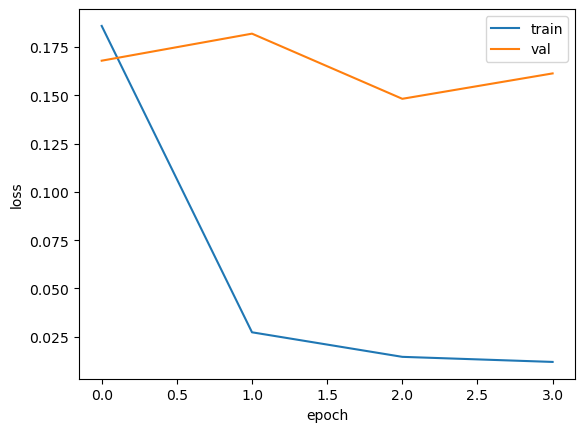

In [11]:
plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
checkpoint = torch.load(f'./save/Q3.2a2_{int(real_portion*100)}%.pt')
net.load_state_dict(checkpoint['lenet'])

test_accuracy, test_predictions, _ = evaluate(test_loader, 10000)
print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Avg. Loss: 0.132687, Accuracy: 0.970300
Test Accuracy = 0.970


# Finetune

In [13]:
for e in range(1, 5):
    train_loss = train(e, real_loader)
    validation_accuracy, validation_predictions, val_loss = evaluate(valid_loader)
    train_loss_hist.append(train_loss.item())
    val_loss_hist.append(val_loss.item())
    print("EPOCH {} ...".format(e))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
    if validation_accuracy > best_val_acc:
        validation_accuracy = best_val_acc

        torch.save(
            {
                'lenet': net.state_dict(),
            },
            (f'./save/Q3.2a2_{int(real_portion*100)}%.pt'),
        )
        print("Model saved")
        print()

Train - Epoch 1, Batch: 0, Loss: 0.034149
Train - Epoch 1, Batch: 10, Loss: 0.106816
Train - Epoch 1, Batch: 20, Loss: 0.076722
Train - Epoch 1, Batch: 30, Loss: 0.174010
Train - Epoch 1, Batch: 40, Loss: 0.080917
Train - Epoch 1, Batch: 50, Loss: 0.084269
Train - Epoch 1, Batch: 60, Loss: 0.068841
Train - Epoch 1, Batch: 70, Loss: 0.049252
Train - Epoch 1, Batch: 80, Loss: 0.055099
Train - Epoch 1, Batch: 90, Loss: 0.144939
Train - Epoch 1, Batch: 100, Loss: 0.128758
Train - Epoch 1, Batch: 110, Loss: 0.061211
Train - Epoch 1, Batch: 120, Loss: 0.035035
Train - Epoch 1, Batch: 130, Loss: 0.070267
Train - Epoch 1, Batch: 140, Loss: 0.055808
Train - Epoch 1, Batch: 150, Loss: 0.045298
Train - Epoch 1, Batch: 160, Loss: 0.016456
Train - Epoch 1, Batch: 170, Loss: 0.102908
Train - Epoch 1, Batch: 180, Loss: 0.039892
Train - Epoch 1, Batch: 190, Loss: 0.047463
Train - Epoch 1, Batch: 200, Loss: 0.229668
Train - Epoch 1, Batch: 210, Loss: 0.011625
Train - Epoch 1, Batch: 220, Loss: 0.176152

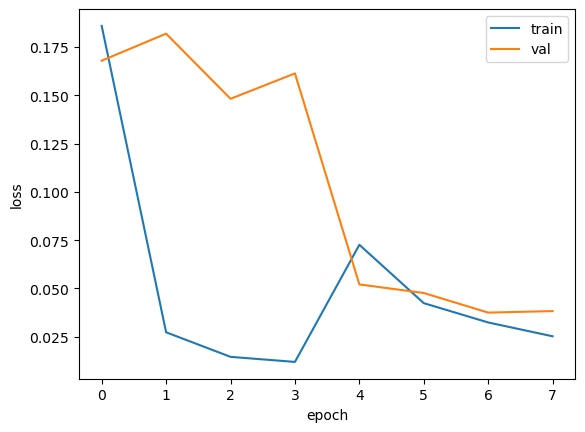

In [14]:
plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
checkpoint = torch.load(f'./save/Q3.2a2_{int(real_portion*100)}%.pt')
net.load_state_dict(checkpoint['lenet'])

test_accuracy, test_predictions, _ = evaluate(test_loader, 10000)
print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Avg. Loss: 0.030661, Accuracy: 0.990700
Test Accuracy = 0.991
